In [1]:
# prelude

import pandas as pd
# import numpy as np
# from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt


# from sklearn.model_selection    import GridSearchCV, train_test_split
# from sklearn.metrics            import precision_score, recall_score, f1_score, accuracy_score
# from sklearn.linear_model       import LogisticRegression
# from sklearn.ensemble           import RandomForestClassifier, GradientBoostingClassifier
# # from sklearn.svm              import SVC
# # from sklearn.neighbors        import KNeighborsClassifier

# from xgboost                    import XGBClassifier 
# from sklearn.pipeline           import Pipeline
# # from sklearn.impute           import SimpleImputer
# from sklearn.compose            import ColumnTransformer
# from sklearn.preprocessing      import OneHotEncoder, StandardScaler, PolynomialFeatures   
# from sklearn.feature_selection  import SelectKBest, f_classif, chi2






# Return pandas DataFrames instead of numpy arrays
# from sklearn import set_config
# set_config(transform_output="pandas") # ! NOT TESTED YET

Gold              = 1.618                          
Width             = 12
Height            = Width/Gold
WidthPx           = 1024
HeightPx          = WidthPx/Gold

# k_result_file       = "models-benchmark"
# k_target            = "converted"
# k_header            = "conversion_data_test_predictions_"
# k_author            = "PHILIPPE"
# k_random_state      = 42            # I know you know ...
# k_final_test_size   = 20/100        # typic. 20% from the set of the intial observations is set aside for final testing (unseen data)
# k_test_size         = 20/100        # typic. 20% of the remaining 80% of the initial observation ui used for the test_set (we should say validation_set)
# k_samples_ratio     = 100/100       # percentage of observations to be taken into account. Pass 100/100 for final testing 
# k_bVerbose          = True          # Enable/disable messages
# k_bPrePrepocessing  = False         # this flag indicates to do pre-preprocessing or not


# Conversion Rate Challenge : EDA

## <span style="color:red"><b>TODO, ideas... - TO BE COMMENTED</b></span>

### TODO
* ~~Pie chart pour illustrer le % de dupliqués~~
    * ~~Justifier la méthode de suppression de dupliqués~~
* ~~Vérifier si les distributions sont normales ou skew => 3 sigma ou 1.5 IQR~~
* ~~Show an example of minimal code without without framework~~
* Use set_config(transform_output="pandas")
* Reorganize code adding a python module 
  * this would help to read the notebook
* add a validation set and make sur to test the mode on unseen data before publication
* see how to transform "preprocessing on df" as a pre processing step
* see how to chain multiple pre processing
* see if it make sense to create a pre processing phase
* fix the vocabulary : 
  * Phase, step... 
  * A phase consists of one or more steps
  * Phases and steps are ordered
* Use ``set_config(transform_output="pandas")``
* review variables names
* ~~Classe déséquilibrées? - SMOTE - Synthetic Minority Oversampling Technique~~
* ~~Bar graph to illustrate 3% and unbalanced classes~~
* ~~can we re run the baseline example on one feature ?~~
  * ~~Yes. See ``Baseline`` selection id ~~
* ~~add graphs in EDA~~
* ~~split the dataset in 3 : train, test and final_test (unseen)~~
* ~~change organization in features engineering~~
* ~~verbosity~~
* ~~<span style="color:red"><b>BUG</b></span> : le dernier fichier de pred est vide ????~~
    * ~~warning at the very end~~

### Ideas
* Remove duplicate ?
* Remove outliers ?
* Lasso for feature selection
* make a test with set_config(transform_output="pandas")
    * see prelude
* ~~support for features engineering~~
* ~~support polyfeatures? Yes~~
* ~~test on one feature. Yes. See Baseline~~
* ~~Support for random forest. Yes~~
* ~~Support for feature selection. Yes~~
* ~~Any co linearity in features ?~~
  * ~~To be added in EDA~~
  * ~~Done with correlation heatmap~~ 
* ~~Are the distributions normal ?~~
  * ~~if needed log or boxCox~~
  * ~~See EDA~~




<!-- 

<span style="color:red"><b>BUG</b></span> : le dernier fichier de pred est vide ????

import ctypes   
ctypes.windll.user32.MessageBoxW(0, "Your text", "Your title", 1)

 -->

In [2]:
df = pd.read_csv('./assets/conversion_data_train.csv')
df.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


In [3]:
print(f"Shape : {df.shape:}")
print()

display(df.describe(include="all").T)


Shape : (284580, 6)



,count,unique,top,freq,mean,std,min,25%,50%,75%,max
country,284580,4,US,160124,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,284580.0,NaN,NaN,NaN,30.564203,8.266789,17.0,24.0,30.0,36.0,123.0
new_user,284580.0,NaN,NaN,NaN,0.685452,0.464336,0.0,0.0,1.0,1.0,1.0
source,284580,3,Seo,139477,NaN,NaN,NaN,NaN,NaN,NaN,NaN
total_pages_visited,284580.0,NaN,NaN,NaN,4.873252,3.341995,1.0,2.0,4.0,7.0,29.0
converted,284580.0,NaN,NaN,NaN,0.032258,0.176685,0.0,0.0,0.0,0.0,1.0


In [15]:
# -----------------------------------------------------------------------------
def quick_View(df):
  summary_lst = []
  
  for col_name in df.columns:
    col_dtype               = df[col_name].dtype
    num_of_null             = df[col_name].isnull().sum()
    percent_of_null         = num_of_null/len(df)
    num_of_non_null         = df[col_name].notnull().sum()
    num_of_distinct_values  = df[col_name].nunique()
    
    if num_of_distinct_values <= 10:
        distinct_values_counts = df[col_name].value_counts().to_dict()
    else:
        top_10_values_counts    = df[col_name].value_counts().head(10).to_dict()
        distinct_values_counts  = {k: v for k, v in sorted(top_10_values_counts.items(), key=lambda item: item[1], reverse=True)}

    if col_dtype != "object":
       max_of_col = df[col_name].max()
       min_of_col = df[col_name].min()
       outlier_hi = df[col_name].mean() + 3*df[col_name].std()
       outlier_lo = df[col_name].mean() - 3*df[col_name].std()
    else:
       max_of_col = -1
       min_of_col =  1
       outlier_hi = -1
       outlier_lo =  1
    
    summary_lst.append({
      "name"                : col_name,
      "dtype"               : col_dtype,
      "# null"              : num_of_null,
      "% null"              : (100*percent_of_null).round(2),
      "# NOT null"          : num_of_non_null,
      "distinct val"        : num_of_distinct_values,
      "-3*sig"              : round(outlier_lo,2) ,
      "min"                 : round(min_of_col,2),
      "max"                 : round(max_of_col,2),
      "+3*sig"              : round(outlier_hi,2) ,
      "distinct val count"  : distinct_values_counts
    })
  
  tmp_df = pd.DataFrame(summary_lst)
  return tmp_df

In [16]:
tmp_df = quick_View(df)
display(tmp_df.sort_values(by="# null", ascending=False))                 

,name,dtype,# null,% null,# NOT null,distinct val,-3*sig,min,max,+3*sig,distinct val count
0,country,object,0,0.0,284580,4,1.00,1,-1,-1.00,"{'US': 160124, 'China': 69122, 'UK': 43641, 'G..."
1,age,int64,0,0.0,284580,60,5.76,17,123,55.36,"{28: 12972, 30: 12956, 29: 12710, 27: 12668, 2..."
2,new_user,int64,0,0.0,284580,2,-0.71,0,1,2.08,"{1: 195066, 0: 89514}"
3,source,object,0,0.0,284580,3,1.00,1,-1,-1.00,"{'Seo': 139477, 'Ads': 80027, 'Direct': 65076}"
4,total_pages_visited,int64,0,0.0,284580,29,-5.15,1,29,14.90,"{2: 39546, 3: 39465, 4: 36918, 1: 36637, 5: 32..."
5,converted,int64,0,0.0,284580,2,-0.50,0,1,0.56,"{0: 275400, 1: 9180}"


### <span style="color:orange"><b>Comments :</b></span>
* 284_580 observations
* 6 features
* Target = converted (boolean)
* Classification problem
* 2 categorical features (country, source) 
* new_user is boolean
* 2 numerical features (age, total_pages_visited)
* There is much more than <span style="color:orange"><b>30*nb_features</b></span> observations, so we should be safe

In [4]:
nb_converted      = df["converted"].sum()
nb_not_converted  = len(df)-nb_converted

print(f"Nb converted               : {nb_converted:>7_}")
print(f"Nb not converted           : {nb_not_converted:>7_}")
percent_converted = (100*nb_converted/(nb_converted+nb_not_converted)).round(2)
print(f"Nb converted as % of total : {percent_converted:>7_} %")

Nb converted               :   9_180
Nb not converted           : 275_400
Nb converted as % of total :    3.23 %


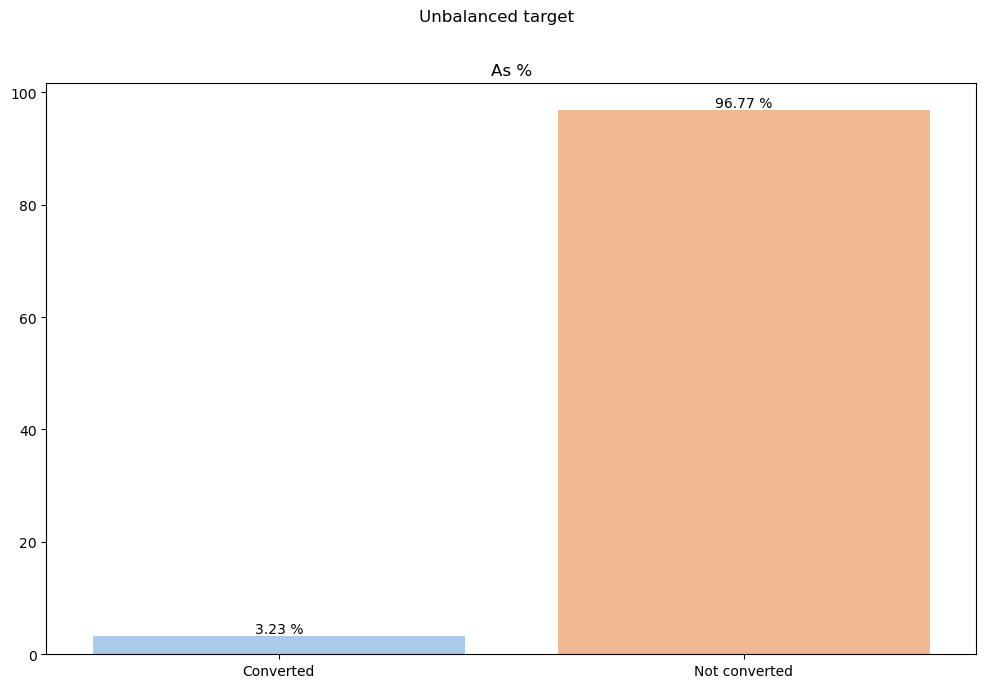

In [5]:
categories  = ['Converted', 'Not converted']
values      = [percent_converted, 100 - percent_converted]

fig, ax = plt.subplots(figsize=(Width,Height))
palette = sns.color_palette("pastel", n_colors=2)

sns.barplot (x=categories, y=values, hue = categories, palette=palette)                 
fig.suptitle("Unbalanced target")
ax.set_title("As %")
for i, val in enumerate(values):
    ax.text(i, val, str(val)+" %", ha='center', va='bottom')

### <span style="color:orange"><b>Comments :</b></span>

* Clearly the target is <span style="color:orange"><b>imbalanced</b></span> between converted and not converted.
* Let's make sure to use ``stratify`` while splitting the dataset
* Some good candidate could be : 
    * Logistic Regression
    * XGBoost (see the scale_pos_weight hyper parameter), 
    * Random Forest 
    * AdaBoost 
    * and, why not, using some oversampling method (SMOTE ?)

In [6]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284580 entries, 0 to 284579
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              284580 non-null  object
 1   age                  284580 non-null  int64 
 2   new_user             284580 non-null  int64 
 3   source               284580 non-null  object
 4   total_pages_visited  284580 non-null  int64 
 5   converted            284580 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 13.0+ MB
None


### <span style="color:orange"><b>Comments :</b></span>

* Should `new_user` be boolean ?
* Idem for `converted` ?


In [7]:
print(f"Number of null values :")
print()
print(100 * df.isnull().sum() / df.shape[0])
# print (df.isnull().any().any())

Number of null values :

country                0.0
age                    0.0
new_user               0.0
source                 0.0
total_pages_visited    0.0
converted              0.0
dtype: float64


### <span style="color:orange"><b>Comments :</b></span>

* No missing values


In [8]:
print(f"Lines duplicated : {df.duplicated().sum():>6_}")
percent_duplicated = (100*df.duplicated().sum()/len(df)).round(2)
print(f"As %             : {percent_duplicated:>9_}%")

Lines duplicated : 268_769
As %             :     94.44%


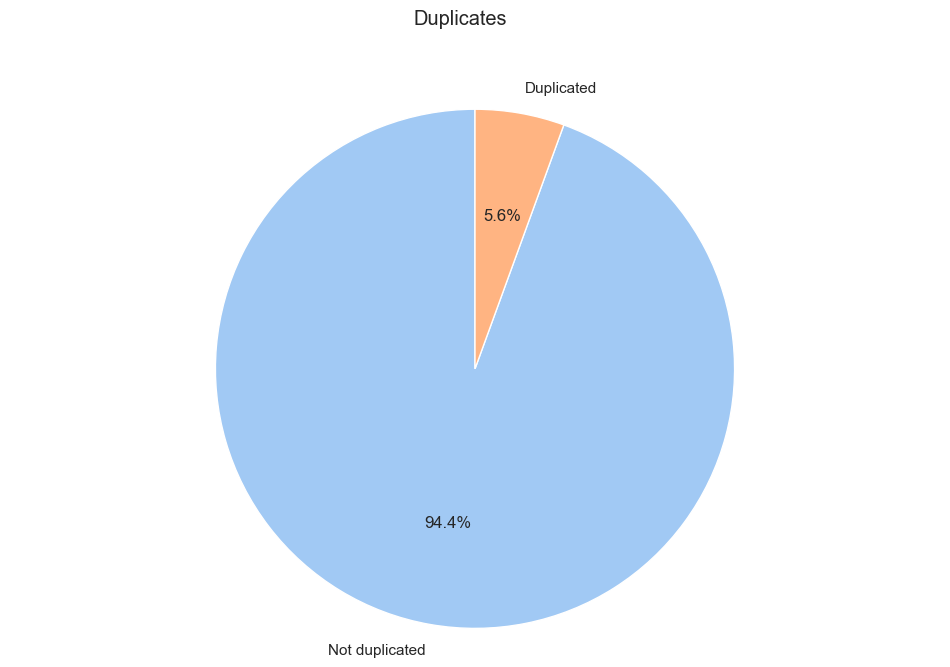

In [18]:
categories  = ['Not duplicated', 'Duplicated']
values      = [percent_duplicated, 100 - percent_duplicated]

fig, ax = plt.subplots(figsize=(Width, Height))
palette = sns.color_palette("pastel",n_colors=2)
ax.pie(values, labels=categories, autopct='%1.1f%%', startangle=90, colors=palette)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
fig.suptitle("Duplicates")
plt.show()

In [10]:
print("Duplicated columns : ", df.columns.duplicated() )
print()

print("Unique countries   : ", df["country"].unique())
print("Unique sources     : ", df["source"].unique())


Duplicated columns :  [False False False False False False]

Unique countries   :  ['China' 'UK' 'Germany' 'US']
Unique sources     :  ['Direct' 'Ads' 'Seo']


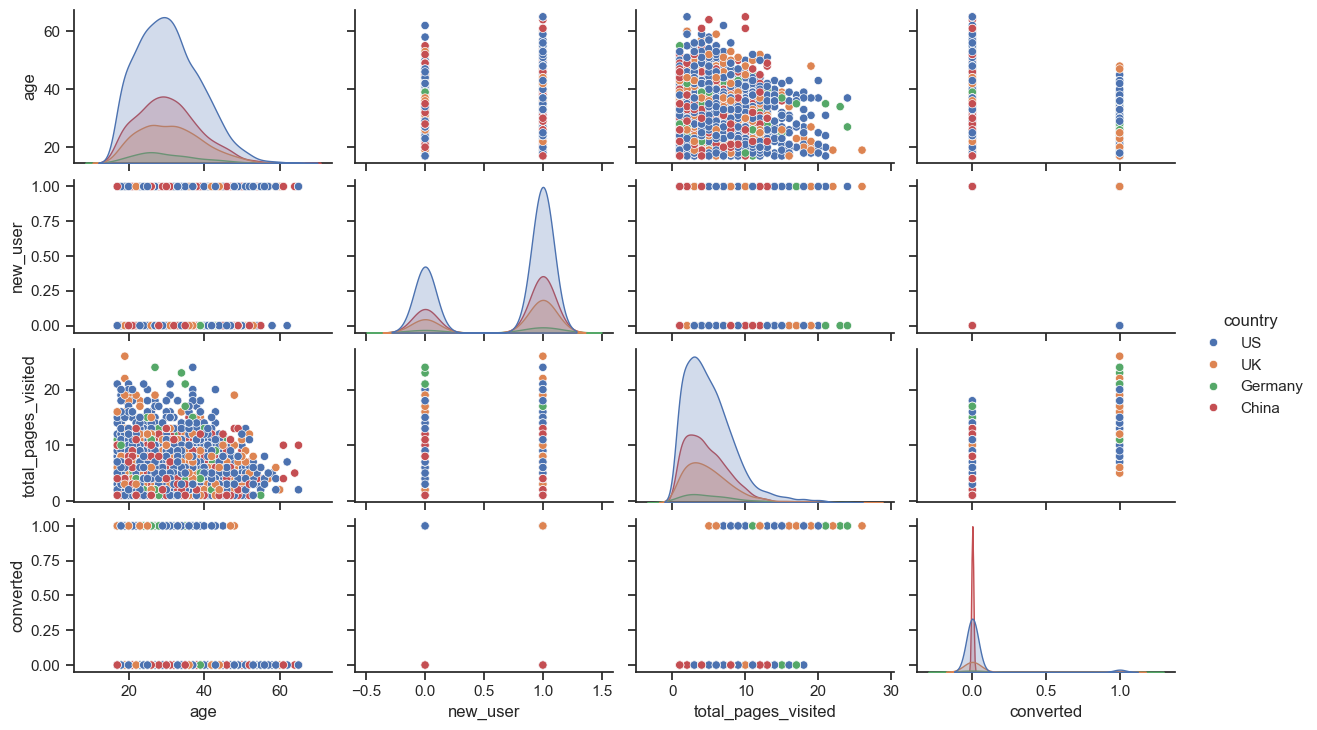

In [11]:
sns.set(style="ticks")
# Note the sample(5000) which helps to speedup things
_ = sns.pairplot(df.sample(5_000), hue="country", height=Height/4, aspect=Gold) 

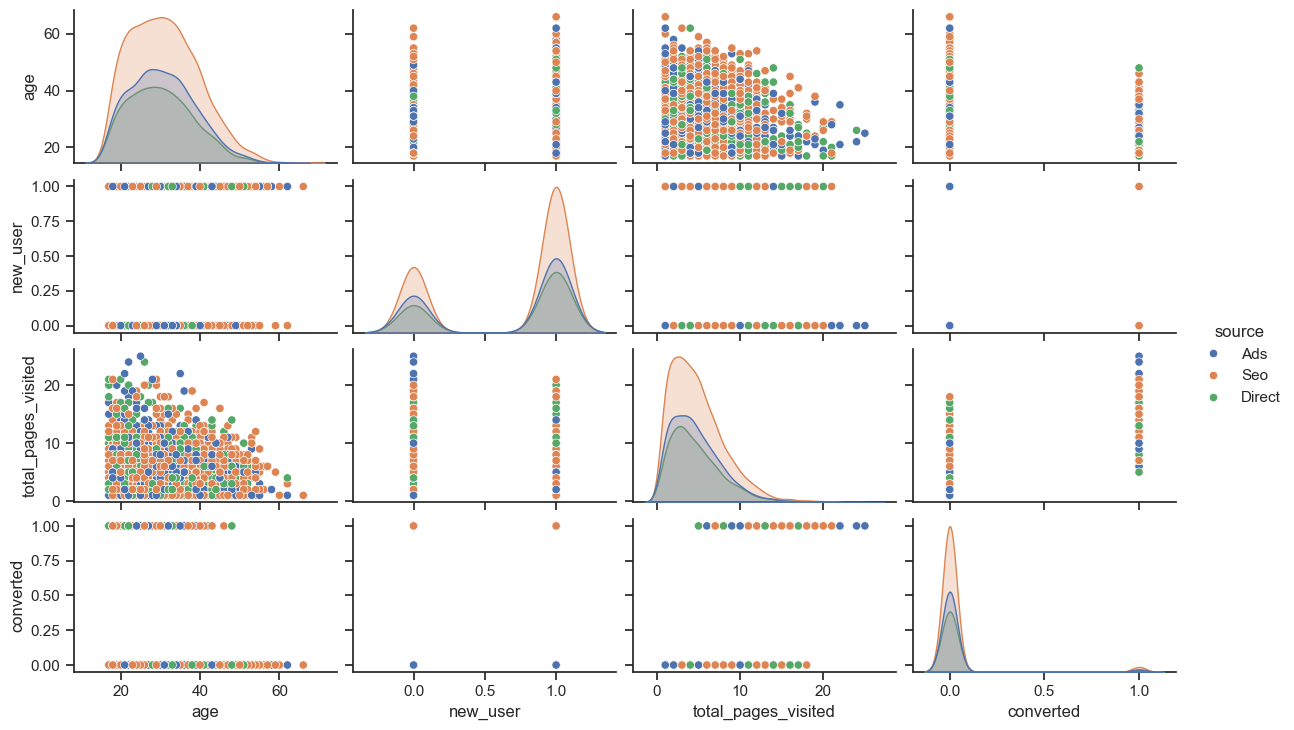

In [12]:
sns.set(style="ticks")
_ = sns.pairplot(df.sample(5_000), hue="source", height=Height/4, aspect=Gold)

### <span style="color:orange"><b>Comments :</b>
* ``total_pages_visited`` and ``age`` are NOT symetrical 
* => If we remove outliers, we should use 1.5 * IQR and NOT the 3 x $\sigma $

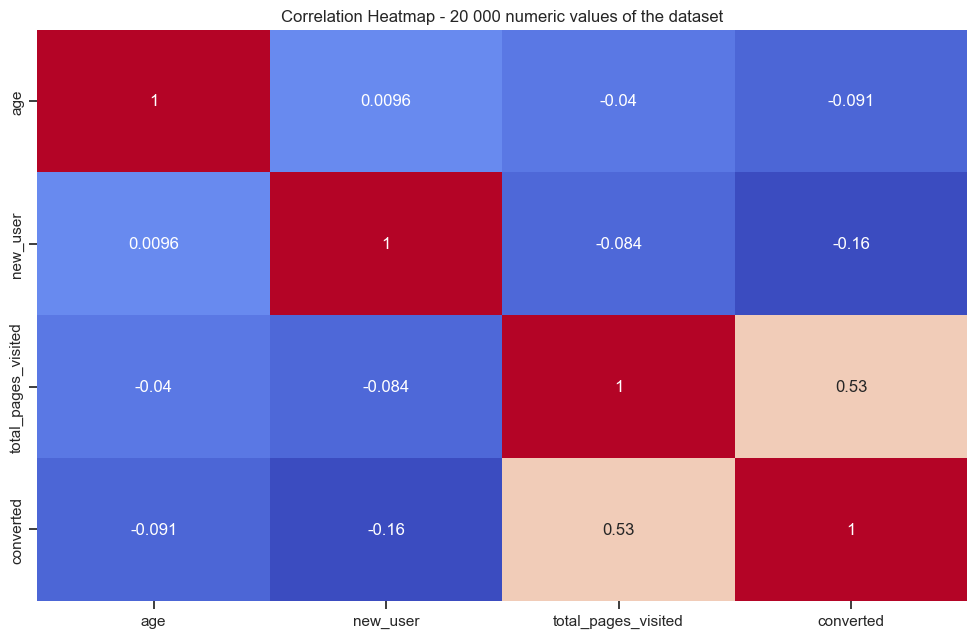

In [13]:

# ! Note the sample(20_000) which helps to speedup things

correlation_matrix = df.sample(20_000).corr(numeric_only=True)
fig, ax = plt.subplots(figsize=(Width, Height))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", cbar=False)
ax.set_title("Correlation Heatmap - 20 000 numeric values of the dataset");


### <span style="color:orange"><b>Comments :</b>
* ``total_page_visited`` and ``converted`` are correlated (not a big surprise) 


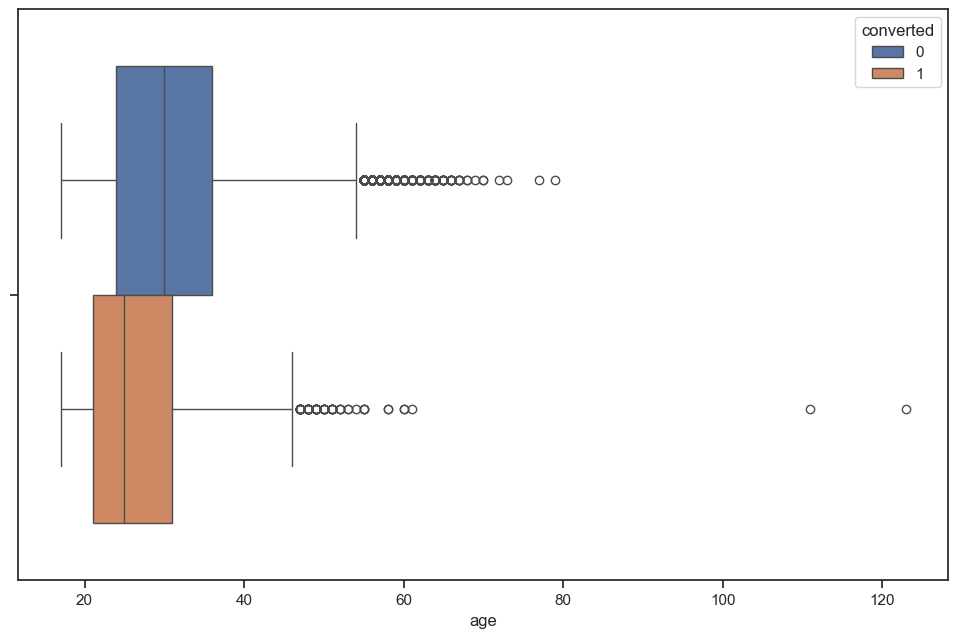

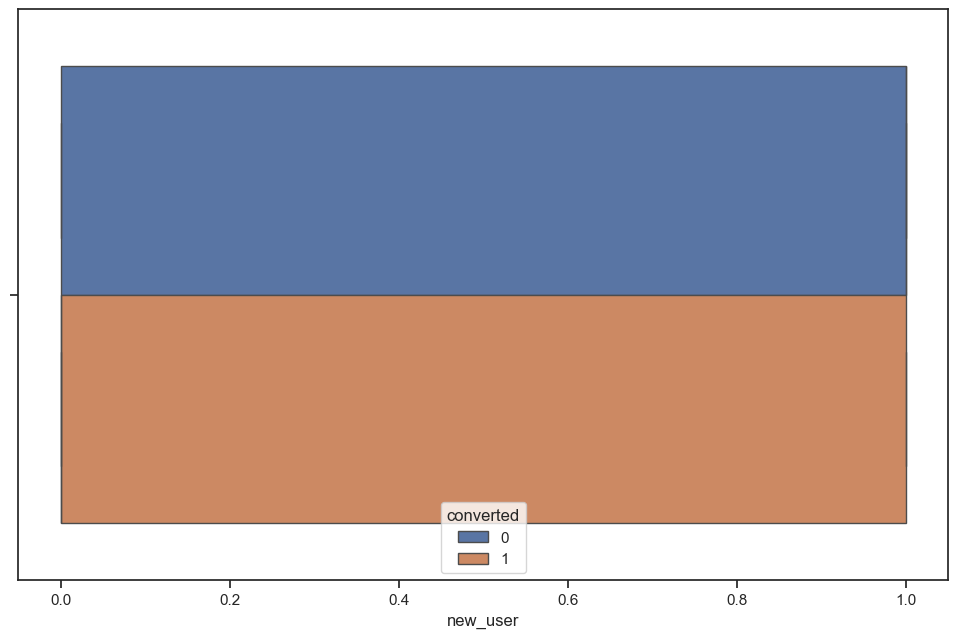

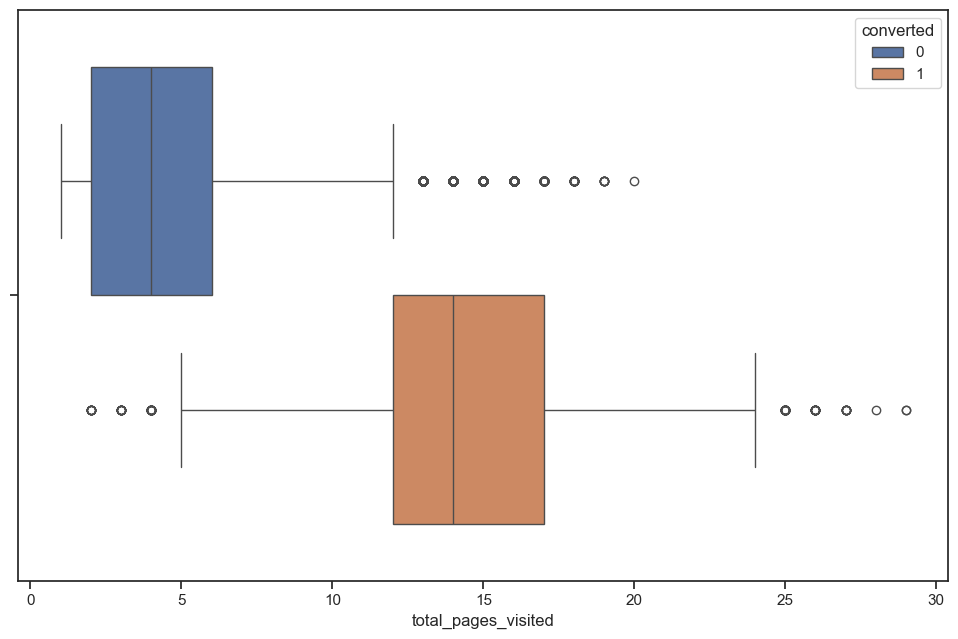

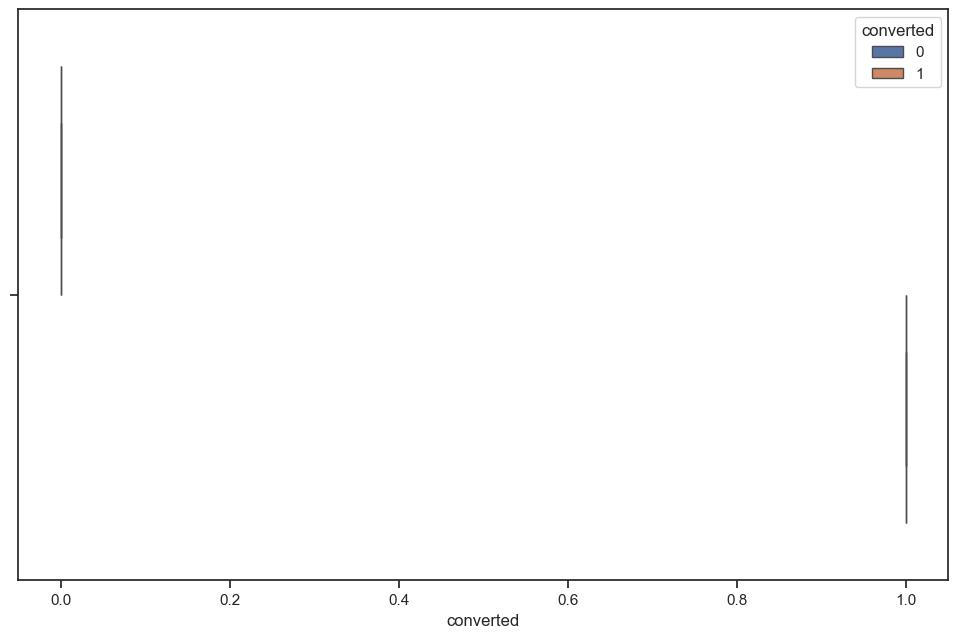

In [14]:
num_feat = df.select_dtypes(include="number").columns

for i, col in enumerate(num_feat):
  fig, ax = plt.subplots(figsize=(Width,Height))
  sns.boxplot(data=df, x=col, hue="converted")
plt.show()


### <span style="color:orange"><b>Comments :</b></span>
* Outliers are mostly in both ``age`` and ``total_page_visited`` features
